In [1]:
# import needed modules
import pandas as pd
import numpy as np
import geopandas as gpd
import osmnx as ox
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.image as mpimg
import matplotlib.offsetbox as offsetbox
import matplotlib.ticker as ticker
import matplotlib.colors as mcolors
from matplotlib.lines import Line2D

from shapely.geometry import Point, Polygon
from shapely.ops import unary_union

import folium
from folium.plugins import MarkerCluster
from folium.plugins import Geocoder

""" data preprocessing """

# define and download OSM-data
# get district and city boundaries
graz_name = "Graz, Austria"

graz_boundary = ox.geocode_to_gdf(graz_name)

name_districts = ["Innere Stadt", "Sankt Leonhard", "Geidorf", "Lend", "Gries", "Jakomini", "Liebenau", "Sankt Peter", 
                  "Waltendorf", "Ries", "Mariatrost", "Andritz", "Gösting", "Eggenberg", "Wetzelsdorf", "Straßgang", "Puntigam"]

tags = {"boundary": "administrative", "admin_level": "9"}

graz_districts = ox.features_from_place(graz_name, tags)
graz_districts = graz_districts[graz_districts.geometry.type.isin(['Polygon', 'MultiPolygon'])]
graz_districts = graz_districts[graz_districts['name'].isin(name_districts)]

# define an EPSG for the whole project, in this case WGS 84 / UTM Zone 33N to fit the research area (Graz)
epsg = 32633

# get needed osm tags for noise at night
osm_tags = {'amenity': ['bar', 'nightclub', 'pub', 'hospital']}
osm_features = ox.features_from_place(graz_name, osm_tags)
osm_features = osm_features.to_crs(epsg=epsg)

# create a function to apply the needed buffers on the different categories 
def apply_buffer(row):
    if row['amenity'] == 'hospital':
        return row.geometry.buffer(150)
    elif row['amenity'] in ['bar', 'pub', 'nightclub']:
        return row.geometry.buffer(50)
    else:
        return row.geometry.buffer(25) 

# use the buffer function
osm_features['geometry'] = osm_features.apply(apply_buffer, axis=1)

# load and preprocess the geopackages (which contain noise information about roads, railways and industry at night)

# set paths
path_industrial_noise = './midterm_project_noise/Agglomerations-StrategicNoiseMaps-multipoly.gpkg'
path_road_noise = './midterm_project_noise/MajorRoads-StrategicNoiseMaps-multipoly.gpkg'
path_railway_noise = './midterm_project_noise/MajorRailways-StrategicNoiseMaps-multipoly.gpkg'

# possible method to get all the layers of the geopackage in order to load it correctly in the script (not needed for the runthrough)

# layers = gpd.io.file.fiona.listlayers(path_railway_noise)
# print("All layers of the gpkg:")
# for it in layers:
#     print(it)

# get the crs of the gpkg-data and set a bounding box, in order to load just the part of the data around the area of graz
# (to save memory and get more efficient processing
gdf_temp = gpd.read_file(path_industrial_noise, layer="NoiseContours_industryInAgglomeration_Lnight", rows=1)

graz_boundary = graz_boundary.to_crs(gdf_temp.crs)

bbox = tuple(graz_boundary.total_bounds)

# read the gpkg data
gdf_industry = gpd.read_file(path_industrial_noise, layer="NoiseContours_industryInAgglomeration_Lnight", bbox=bbox)
gdf_roads = gpd.read_file(path_road_noise, layer="NoiseContours_majorRoadsIncludingAgglomeration_Lnight", bbox=bbox)
gdf_railway = gpd.read_file(path_railway_noise, layer="NoiseContours_majorRailwaysIncludingAgglomeration_Lnight", bbox=bbox)

# convert everything to the predefined EPSG
graz_boundary = graz_boundary.to_crs(epsg=epsg)
graz_districts = graz_districts.to_crs(epsg=epsg)

gdf_industry = gdf_industry.to_crs(epsg=epsg)
gdf_roads = gdf_roads.to_crs(epsg=epsg)
gdf_railway = gdf_railway.to_crs(epsg=epsg)

# clip everything to the boundaries of Graz
gdf_industry = gpd.clip(gdf_industry, graz_boundary)
gdf_roads = gpd.clip(gdf_roads, graz_boundary)
gdf_railway = gpd.clip(gdf_railway, graz_boundary)
osm_features = gpd.clip(osm_features, graz_boundary)

# filtering after db amount of the geopackages (above 50 db)

# to do so, we wrote a function which changes the entries of the dataset into integer
def extract_db(value):
    if value.startswith('Lnight') and value[6:].isdigit():
        numeric_part = value.replace('Lnight', '')
        db_value = int(numeric_part[:-2]) + int(numeric_part[-2:]) / 100.0
        
        return db_value
        
# with this function, we are able to create a new column in each gdf
gdf_industry['category'] = gdf_industry['category'].apply(extract_db)
gdf_roads['category'] = gdf_roads['category'].apply(extract_db)
gdf_railway['category'] = gdf_railway['category'].apply(extract_db)

# and we can filter the data afterwards for the needed db amount
gdf_industry_filtered = gdf_industry[gdf_industry['category'] > 50]
gdf_roads_filtered = gdf_roads[gdf_roads['category'] > 50]
gdf_railway_filtered = gdf_railway[gdf_railway['category'] > 50]


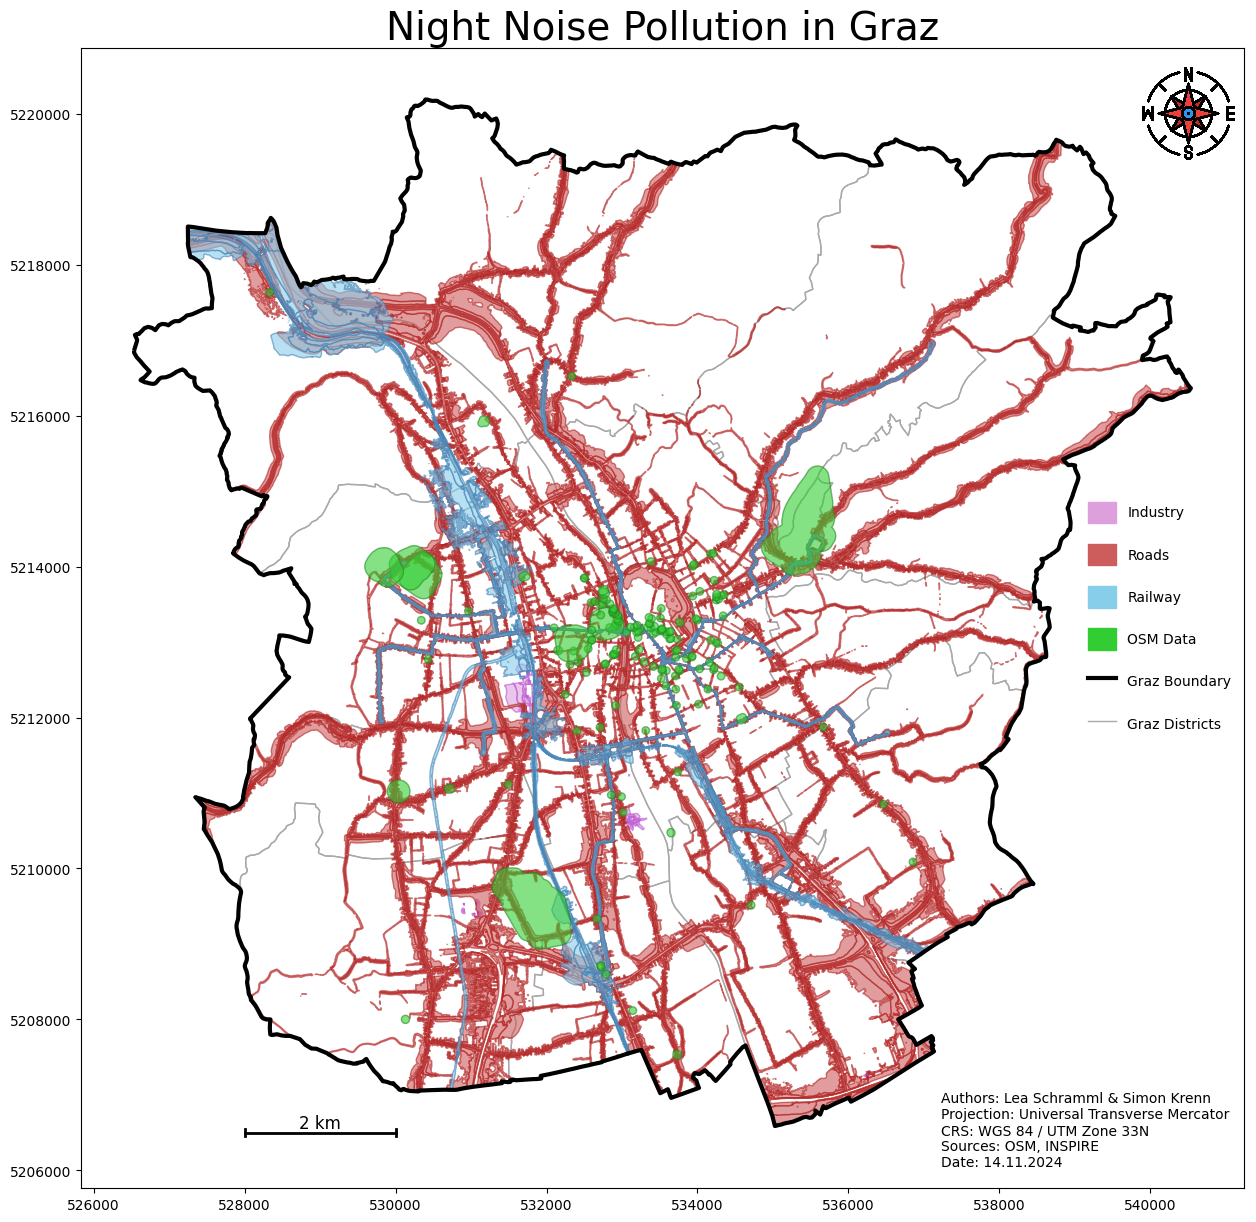

In [2]:
""" creating a first map of the combined noise sources """

fig, ax = plt.subplots(figsize=(15, 15))

# plot the needed datasets in an appeling format (color, width, correct overlap with zorder, etc.)
graz_boundary.plot(ax=ax, color='none', edgecolor='black', linewidth=3, zorder=50)
graz_districts.plot(ax=ax, color='none', edgecolor='darkgrey', linewidth=1)

gdf_industry_filtered.plot(ax=ax, color='plum', edgecolor='mediumorchid', alpha=0.6)
gdf_roads_filtered.plot(ax=ax, color='indianred', edgecolor='firebrick', alpha=0.6)
gdf_railway_filtered.plot(ax=ax, color='skyblue', edgecolor='steelblue', alpha=0.6)
osm_features.plot(ax=ax, color='limegreen', edgecolor='forestgreen', alpha=0.6)

# create a fitting legend
legend_patches = [
    mpatches.Patch(color='plum', label='Industry'),
    mpatches.Patch(color='indianred', label='Roads'),
    mpatches.Patch(color='skyblue', label='Railway'),
    mpatches.Patch(color='limegreen', label='OSM Data'),
    Line2D([0], [0], color='black', linewidth=3, label='Graz Boundary'),
    Line2D([0], [0], color='darkgrey', linewidth=1, label='Graz Districts')
]
plt.legend(handles=legend_patches, loc='center right', handleheight=2, labelspacing=1.5,frameon=False)

# define the position of the north arrow
north_arrow_x = 540500  
north_arrow_y = 5220000  

# read the image of the north arrow into the project
img = mpimg.imread('./midterm_project_noise/north_arrow.png')  

# insert the image into the map
imagebox = offsetbox.OffsetImage(img, zoom=0.035)  
ab = offsetbox.AnnotationBbox(imagebox, (north_arrow_x, north_arrow_y), frameon=False)
ax.add_artist(ab)

# dismiss scientific formats (eg. 1e6) of the axis
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '%1.0f' % x))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '%1.0f' % x))

# define and create a scale bar (more or less manually)
scale_length = 2000  
scale_x = 528000  
scale_y = 5206500  

ax.plot([scale_x, scale_x + scale_length], [scale_y, scale_y], color='black', linewidth=2)

# create small vertical lines for a better scale bar
ax.plot([scale_x, scale_x], [scale_y - 50, scale_y + 50], color='black', linewidth=2)  
ax.plot([scale_x + scale_length, scale_x + scale_length], [scale_y - 50, scale_y + 50], color='black', linewidth=2)

# insert the label for the scale bar
ax.text(scale_x + scale_length / 2, scale_y + 10, '2 km', fontsize=12, ha='center', va='bottom')

# create a new text box inside the map for additional information like authors, projection and so on
text_x = 0.74   
text_y = 0.002  

# content of the text box
text_content = """
Authors: Lea Schramml & Simon Krenn
Projection: Universal Transverse Mercator
CRS: WGS 84 / UTM Zone 33N
Sources: OSM, INSPIRE
Date: 14.11.2024
"""

# insert the text box in a fitting size color, and so on
plt.text(
    text_x, text_y, text_content, ha='left', va='bottom', 
    transform=ax.transAxes, fontsize=10, color='black'
)

plt.title('Night Noise Pollution in Graz', fontsize=28)
output_file_GNM = "graz_noise_map_night.jpg"
plt.savefig(output_file_GNM, dpi=500, format='jpg', bbox_inches='tight')

plt.show()


In [3]:
""" area based analysis of the data """

# calculate the area of each district and save it in a new column
graz_districts['district_area'] = graz_districts.geometry.area

# initialise lists for the area of each noise type
noise_areas = {
    'district': [], 
    'industry_noise_area': [], 
    'road_noise_area': [], 
    'railway_noise_area': [],
    'osm_noise_area': [],
    'total_noise_area': []
}

# calculate the area of each noise source (A part of the following code was generated using the AI model ChatGPT by OpenAI (accessed on [05.11.2024]))
for idx, district in graz_districts.iterrows():
    district_geometry = district.geometry

    # clip the noise area for each district and unify polygons to avoid overlapping
    industry_noise_clipped = unary_union(gpd.clip(gdf_industry_filtered, district_geometry).geometry)
    road_noise_clipped = unary_union(gpd.clip(gdf_roads_filtered, district_geometry).geometry)
    railway_noise_clipped = unary_union(gpd.clip(gdf_railway_filtered, district_geometry).geometry)
    osm_noise_clipped = unary_union(gpd.clip(osm_features, district_geometry).geometry)

    # calculate the area of the unified noise sources in every district for each noise type (and respect empty entries)
    industry_noise_area = industry_noise_clipped.area if not industry_noise_clipped.is_empty else 0
    road_noise_area = road_noise_clipped.area if not road_noise_clipped.is_empty else 0
    railway_noise_area = railway_noise_clipped.area if not railway_noise_clipped.is_empty else 0
    osm_noise_area = osm_noise_clipped.area if not osm_noise_clipped.is_empty else 0

    # unify all noise areas
    all_noises_union = unary_union([industry_noise_clipped, road_noise_clipped, railway_noise_clipped, osm_noise_clipped])
    total_noise_area = all_noises_union.area if not all_noises_union.is_empty else 0

    # save the results
    noise_areas['district'].append(district['name'])
    noise_areas['industry_noise_area'].append(industry_noise_area)
    noise_areas['road_noise_area'].append(road_noise_area)
    noise_areas['railway_noise_area'].append(railway_noise_area)
    noise_areas['osm_noise_area'].append(osm_noise_area)
    noise_areas['total_noise_area'].append(total_noise_area)

# create a df with the calculated noise areas for each district 
noise_areas_df = pd.DataFrame(noise_areas)

# add the area of each district
noise_areas_df = noise_areas_df.merge(graz_districts[['name', 'district_area']], left_on='district', right_on='name')
noise_areas_df.drop(columns=['name'], inplace=True)

# calculate the relative noise pollution in every district for each noise type
noise_areas_df['industry_noise_pct'] = (noise_areas_df['industry_noise_area'] / noise_areas_df['district_area']) * 100
noise_areas_df['road_noise_pct'] = (noise_areas_df['road_noise_area'] / noise_areas_df['district_area']) * 100
noise_areas_df['railway_noise_pct'] = (noise_areas_df['railway_noise_area'] / noise_areas_df['district_area']) * 100
noise_areas_df['osm_noise_pct'] = (noise_areas_df['osm_noise_area'] / noise_areas_df['district_area']) * 100

# create an additional column for the total noise percentage of noise pollution for eacht district
noise_areas_df['total_noise_pct'] = (noise_areas_df['total_noise_area'] / noise_areas_df['district_area']) * 100

# sort the result by total noise percentage
noise_areas_df = noise_areas_df.sort_values(by='total_noise_pct', ascending=False)

# print the results and save the df as a csv-file (if necessary)

#print(noise_areas_df[['district', 'industry_noise_pct', 'road_noise_pct', 'railway_noise_pct', 'osm_noise_pct', 'total_noise_pct']])
#noise_areas_df.to_csv("noise_areas_df.csv", index=False)

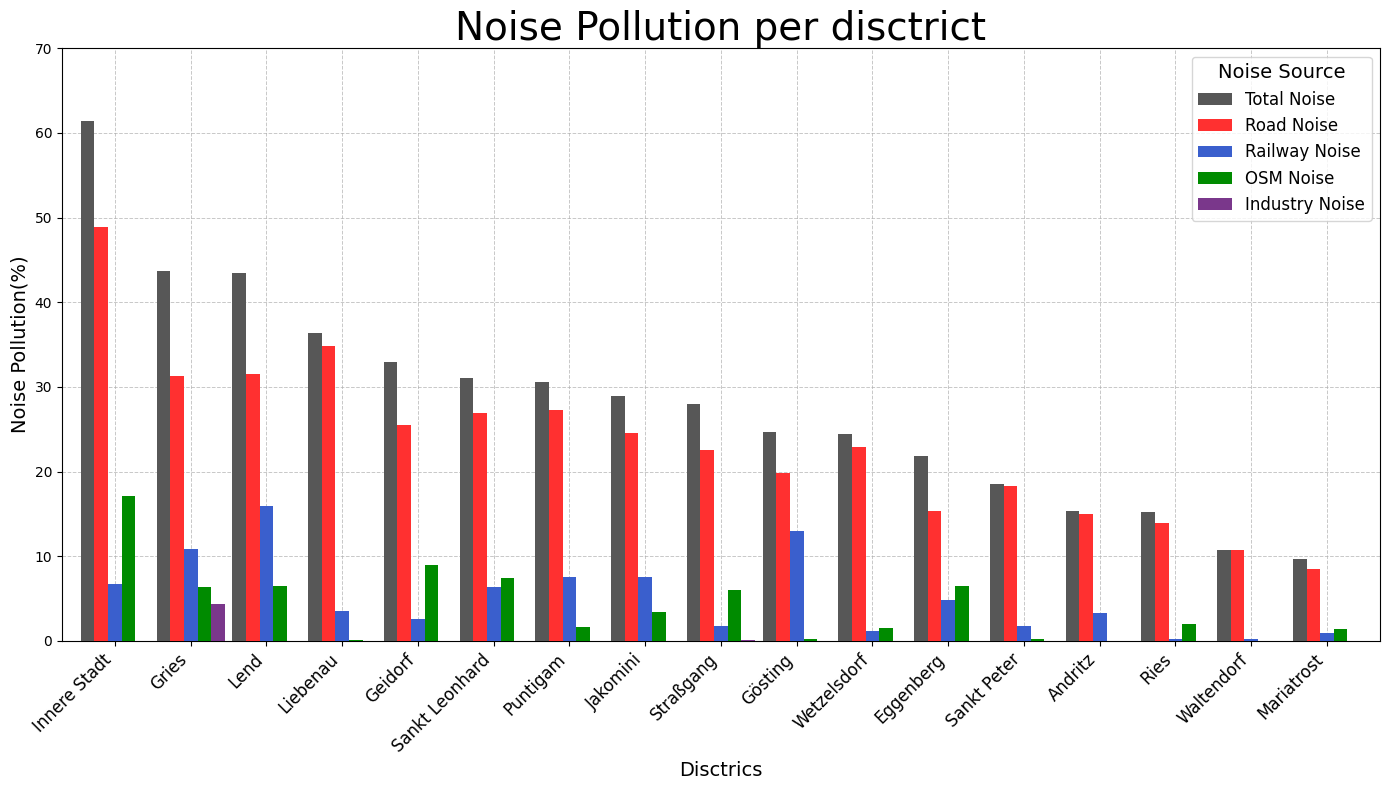

In [4]:
""" creation of various diagrams """
# create an initial diagram for first insights about the data

# define needed parts of the data
columns_to_plot = ['total_noise_pct', 'road_noise_pct', 'railway_noise_pct', 'osm_noise_pct', 'industry_noise_pct']
plot_data = noise_areas_df[['district'] + columns_to_plot].set_index('district')

#colors for diagram
colors = ['#575757', '#ff3030', '#3a5fcd', '#008b00', '#7a378b']
fig, ax = plt.subplots(figsize=(14, 8))
plot_data.plot(kind='bar', stacked=False, ax=ax, width=0.9, zorder=3, color=colors)

# add labels, title, grid, legend and so on
ax.set_title('Noise Pollution per disctrict', fontsize=28)
ax.set_ylabel('Noise Pollution(%)', fontsize=14)
ax.set_xlabel('Disctrics', fontsize=14)
ax.legend(title='Noise Source', labels= ['Total Noise', 'Road Noise', 'Railway Noise', 'OSM Noise', 'Industry Noise'],fontsize=12, title_fontsize=14)
ax.set_xticklabels(plot_data.index, rotation=45, ha='right', fontsize=12)
ax.set_ylim(0, 70)
ax.yaxis.set_ticks(range(0, 71, 10))
ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.7, zorder=0)
ax.grid(axis='x', linestyle='--', linewidth=0.7, alpha=0.7, zorder=0)

plt.tight_layout()

output_file_diagram1 = "graz_noise_map_diagram1.jpg"
plt.savefig(output_file_diagram1, dpi=500, format='jpg', bbox_inches='tight')

plt.show()

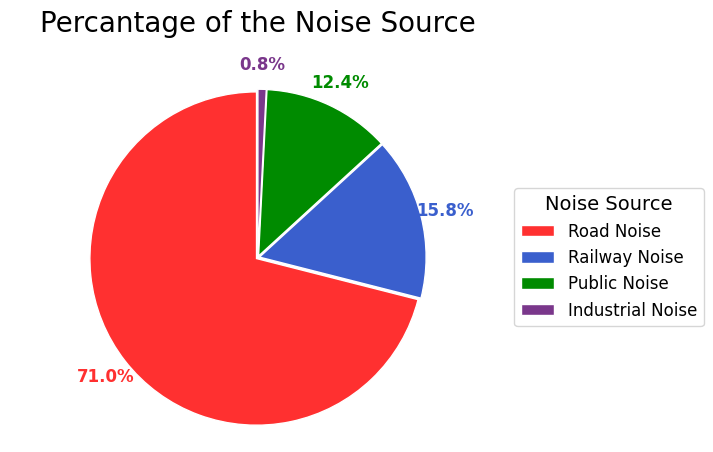

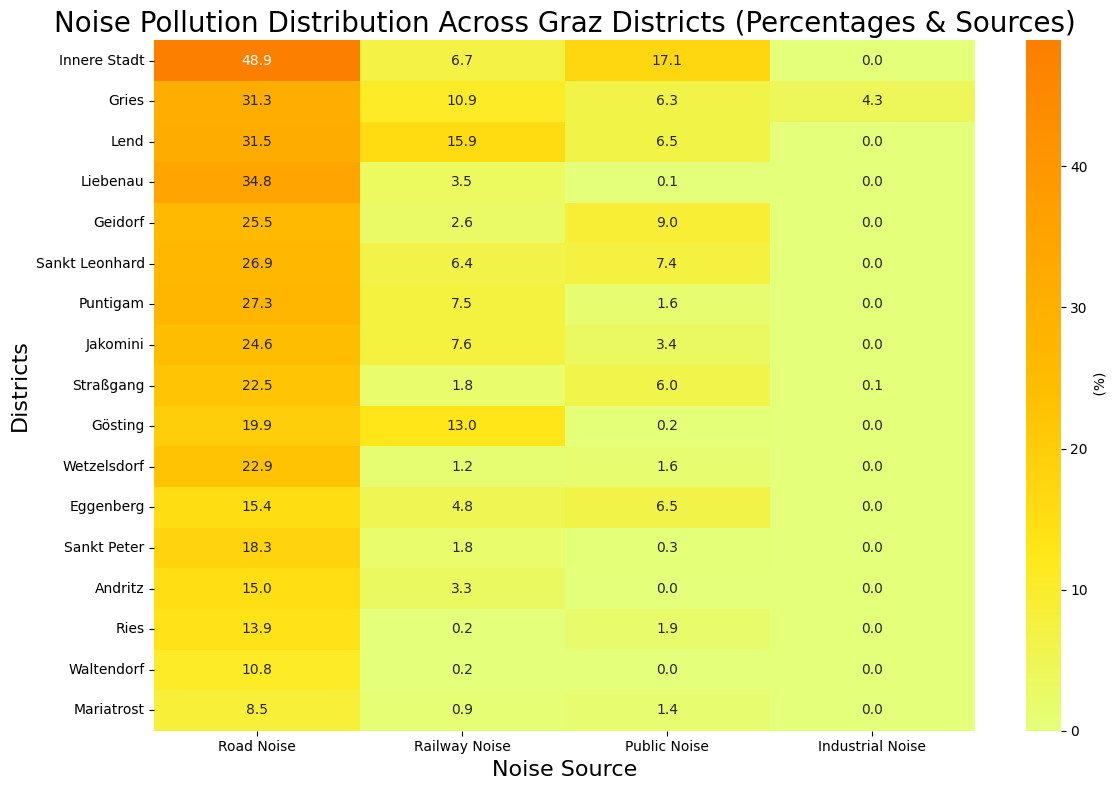

In [5]:
# create further diagrams
# creation of a pie chart to get the distribution of noise sources for all districts combined
combined_totals = noise_areas_df[['road_noise_pct', 'railway_noise_pct', 'osm_noise_pct', 'industry_noise_pct']].sum()
labels = ['Road Noise', 'Railway Noise', 'Public Noise', 'Industrial Noise']
sizes = combined_totals.values
colors_pie = ['#ff3030', '#3a5fcd', '#008b00', '#7a378b']
fig1, ax1 = plt.subplots()

# special plotting commands to create an extraordinary pie chart
patches, texts, pcts = ax1.pie(sizes,explode=[0.01]*4, autopct='%1.1f%%', pctdistance=1.15, startangle=90, wedgeprops={'linewidth': 1.0, 'edgecolor': 'white'},
    textprops={'size': 'large'}, colors = colors_pie, labeldistance=1.4)
ax1.axis('equal') 
for i, p in enumerate(pcts):
    p.set_color(colors_pie[i])
    p.set_fontweight('bold')
plt.setp(texts, fontweight=550)
ax1.legend(patches, labels, title="Noise Source", fontsize=12, title_fontsize=14, loc="center left", bbox_to_anchor=(1, 0.5))
plt.title("Percantage of the Noise Source\n", fontsize=20)

output_file_diagram2 = "graz_noise_map_diagram2.jpg"
plt.savefig(output_file_diagram2, dpi=500, format='jpg', bbox_inches='tight')

plt.show()

# create a heat map for intensity of the noise pollution and to recognise patterns/find similar districts
heatmap_data = noise_areas_df[['district', 'road_noise_pct', 'railway_noise_pct', 'osm_noise_pct', 'industry_noise_pct']]
heatmap_data.set_index('district', inplace=True)
heatmap_data.columns = ['Road Noise', 'Railway Noise', 'Public Noise', 'Industrial Noise']

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".1f", cmap="Wistia", cbar_kws={'label': ' (%)'})
plt.title("Noise Pollution Distribution Across Graz Districts (Percentages & Sources)", fontsize=20)
plt.ylabel("Districts", fontsize=16)
plt.xlabel("Noise Source", fontsize=16)
plt.tight_layout()

output_file_diagram3 = "graz_noise_map_diagram3.jpg"
plt.savefig(output_file_diagram3, dpi=500, format='jpg', bbox_inches='tight')

plt.show()

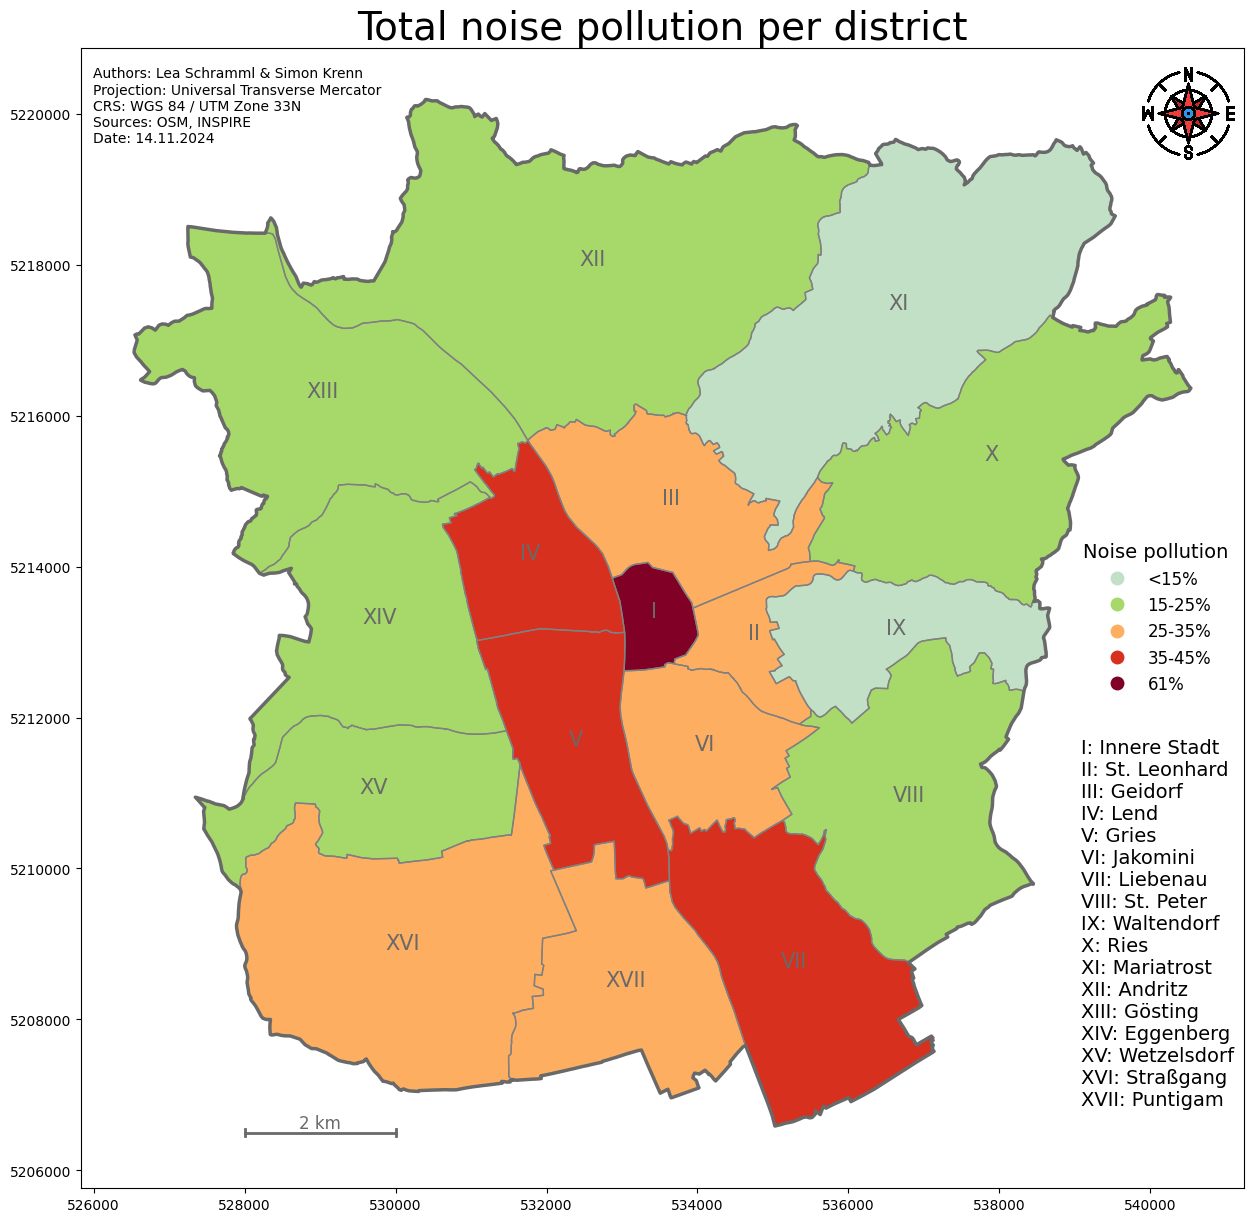

In [6]:
""" creation of maps which categorise the distrcits based on the used noise type """

# add a column with roman letters for better map labels (regarding their usage in the city of Graz itself)
graz_districts['roman_letters'] = ['I', 'VII', 'II', 'III', 'IV', 'V', 'VI', 'VIII', 'IX', 'X', 'XI', 'XII', 'XIII', 'XIV', 'XV', 'XVI', 'XVII']

# create categories for the noise type and define the color gradient
categories = [
    "<15%", "15-25%", "25-35%", "35-45%", "61%"
]
category_bins = [0, 15, 25, 35, 45, float('inf')]
colors = ["#c2e0c6", "#a6d96a", "#fdae61", "#d7301f", "#800026"]

# create a new column, based on the categorie
noise_areas_df['noise_category'] = pd.cut(
    noise_areas_df['total_noise_pct'], 
    bins=category_bins, 
    labels=categories,
    include_lowest=True)

# merge the df with the geometry of the distrcits, based on the name of the district
graz_districts_categorised = graz_districts.merge(noise_areas_df[['district', 'noise_category']], left_on='name', right_on='district')

# create the map
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

# color coding of the categories
graz_districts_categorised.plot(
    column='noise_category', 
    cmap=mcolors.ListedColormap(colors), 
    legend=True,
    legend_kwds={'title': "Noise pollution", 'loc': 'center right', 'frameon': False, 'fontsize':12, 'title_fontsize':14},
    ax=ax
)

graz_boundary.plot(ax=ax, edgecolor="dimgrey", facecolor="none", linewidth=2.5, zorder = 50,)
graz_districts.plot(ax=ax, edgecolor="grey", facecolor="none", linewidth=1,)

# labelling of the districts
for idx, row in graz_districts.iterrows():
    plt.annotate(
        text=row['roman_letters'], 
        xy=(row.geometry.centroid.x, row.geometry.centroid.y),
        ha='center', color='dimgrey', fontsize=15, zorder=100
    )

# create the scale bar in the same way as before (as well as the north arrow)
scale_length = 2000  
scale_x = 528000  
scale_y = 5206500  

ax.plot([scale_x, scale_x + scale_length], [scale_y, scale_y], color='dimgrey', linewidth=2)

ax.plot([scale_x, scale_x], [scale_y - 50, scale_y + 50], color='dimgrey', linewidth=2)  
ax.plot([scale_x + scale_length, scale_x + scale_length], [scale_y - 50, scale_y + 50], color='dimgrey', linewidth=2)  

ax.text(scale_x + scale_length / 2, scale_y + 10, '2 km', fontsize=12, ha='center', va='bottom', color='dimgrey')

north_arrow_x = 540500  
north_arrow_y = 5220000

img = mpimg.imread('./midterm_project_noise/north_arrow.png')  

imagebox = offsetbox.OffsetImage(img, zoom=0.035)  
ab = offsetbox.AnnotationBbox(imagebox, (north_arrow_x, north_arrow_y), frameon=False)
ax.add_artist(ab)

text_x = 0.01
text_y = 0.90 

# create text boxes again
text_content = """
Authors: Lea Schramml & Simon Krenn
Projection: Universal Transverse Mercator
CRS: WGS 84 / UTM Zone 33N
Sources: OSM, INSPIRE
Date: 14.11.2024
"""

plt.text(
    text_x, text_y, text_content, ha='left', va='bottom', 
    transform=ax.transAxes, fontsize=10, color='black'
)

text_districts = """
I: Innere Stadt
II: St. Leonhard
III: Geidorf
IV: Lend
V: Gries
VI: Jakomini
VII: Liebenau
VIII: St. Peter
IX: Waltendorf
X: Ries
XI: Mariatrost
XII: Andritz
XIII: Gösting
XIV: Eggenberg
XV: Wetzelsdorf
XVI: Straßgang
XVII: Puntigam
"""

text_x_districts = 0.86
text_y_districts = 0.05

plt.text(
    text_x_districts, text_y_districts, text_districts, ha='left', va='bottom', 
    transform=ax.transAxes, fontsize=14, color='black'
)

ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '%1.0f' % x))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '%1.0f' % x))

ax.set_title("Total noise pollution per district", fontsize=28)

# adapt the legend
legend = ax.get_legend()
for text, color in zip(categories, colors):
    legend.get_texts()[categories.index(text)].set_text(text)

output_file_TN = "graz_noise_map_TN.jpg"
plt.savefig(output_file_TN, dpi=500, format='jpg', bbox_inches='tight')

plt.show()

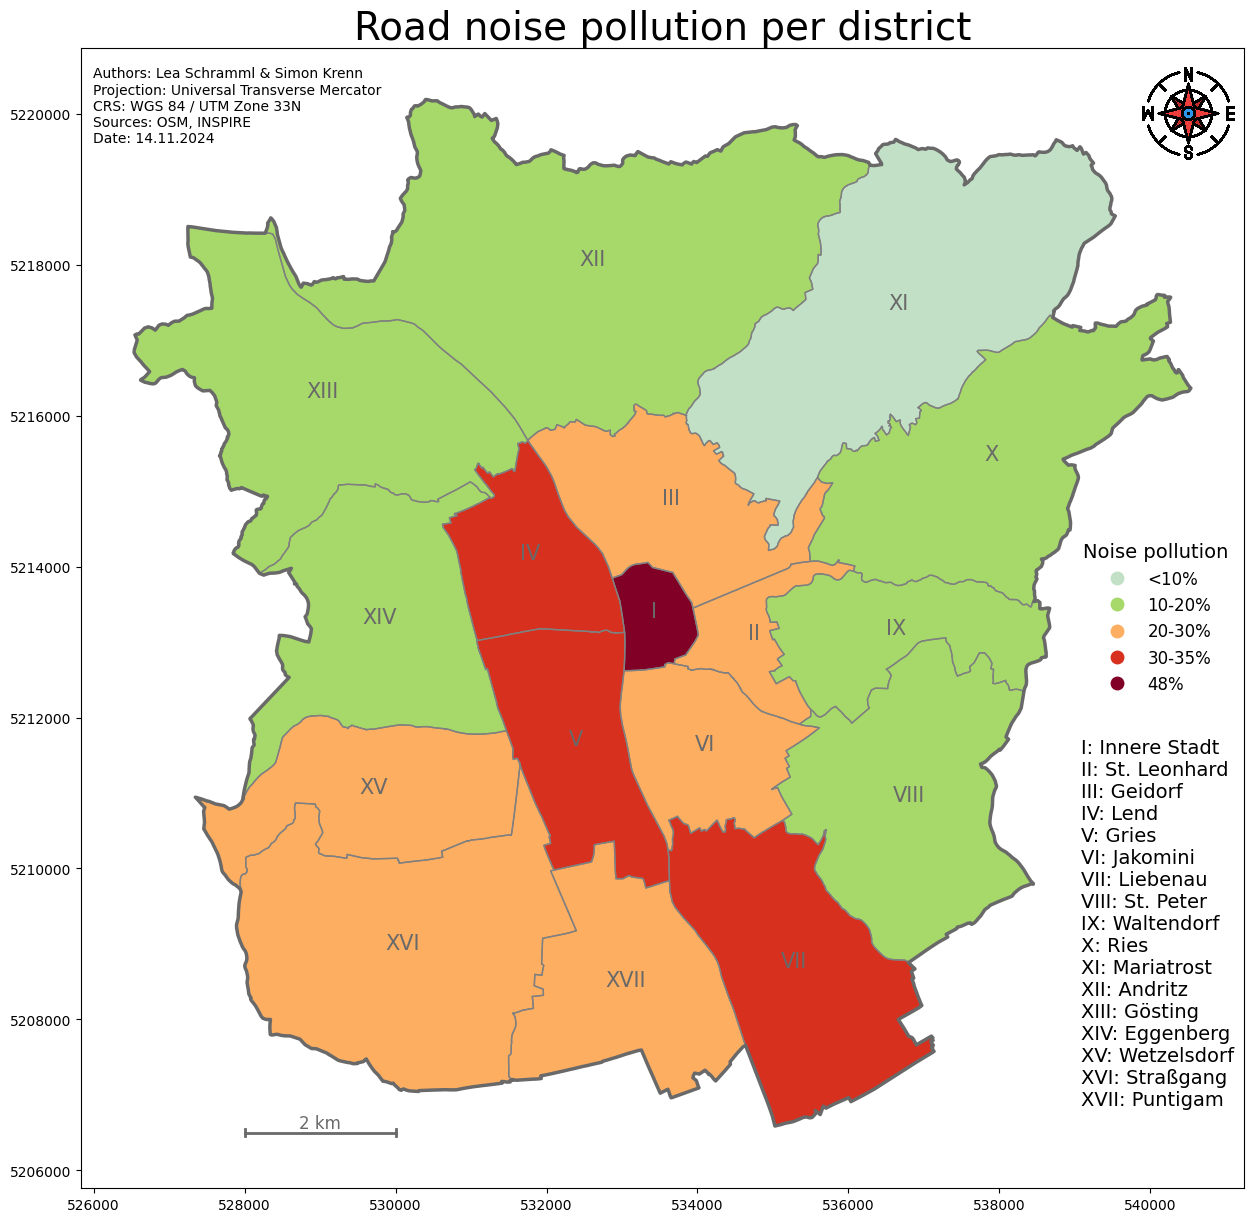

In [7]:
""" creation of maps which categorise the distrcits based on the used noise type """

# add a column with roman letters for better map labels (regarding their usage in the city of Graz itself)
graz_districts['roman_letters'] = ['I', 'VII', 'II', 'III', 'IV', 'V', 'VI', 'VIII', 'IX', 'X', 'XI', 'XII', 'XIII', 'XIV', 'XV', 'XVI', 'XVII']

# create categories for the noise type and define the color gradient
categories = [
    "<10%", "10-20%", "20-30%", "30-35%", "48%"
]
category_bins = [0,10, 20, 30, 35, float('inf')]
colors = ["#c2e0c6", "#a6d96a", "#fdae61", "#d7301f", "#800026"]

# create a new column, based on the categorie
noise_areas_df['noise_category'] = pd.cut(
    noise_areas_df['road_noise_pct'], 
    bins=category_bins, 
    labels=categories,
    include_lowest=True)

# merge the df with the geometry of the distrcits, based on the name of the district
graz_districts_categorised = graz_districts.merge(noise_areas_df[['district', 'noise_category']], left_on='name', right_on='district')

# create the map
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

# color coding of the categories
graz_districts_categorised.plot(
    column='noise_category', 
    cmap=mcolors.ListedColormap(colors), 
    legend=True,
    legend_kwds={'title': "Noise pollution", 'loc': 'center right', 'frameon': False, 'fontsize':12, 'title_fontsize':14},
    ax=ax
)

graz_boundary.plot(ax=ax, edgecolor="dimgrey", facecolor="none", linewidth=2.5, zorder = 50,)
graz_districts.plot(ax=ax, edgecolor="grey", facecolor="none", linewidth=1,)

# labelling of the districts
for idx, row in graz_districts.iterrows():
    plt.annotate(
        text=row['roman_letters'], 
        xy=(row.geometry.centroid.x, row.geometry.centroid.y),
        ha='center', color='dimgrey', fontsize=15, zorder=100
    )

# create the scale bar in the same way as before (as well as the north arrow)
scale_length = 2000  
scale_x = 528000  
scale_y = 5206500  

ax.plot([scale_x, scale_x + scale_length], [scale_y, scale_y], color='dimgrey', linewidth=2)

ax.plot([scale_x, scale_x], [scale_y - 50, scale_y + 50], color='dimgrey', linewidth=2)  
ax.plot([scale_x + scale_length, scale_x + scale_length], [scale_y - 50, scale_y + 50], color='dimgrey', linewidth=2)  

ax.text(scale_x + scale_length / 2, scale_y + 10, '2 km', fontsize=12, ha='center', va='bottom', color='dimgrey')

north_arrow_x = 540500  
north_arrow_y = 5220000

img = mpimg.imread('./midterm_project_noise/north_arrow.png')  

imagebox = offsetbox.OffsetImage(img, zoom=0.035)  
ab = offsetbox.AnnotationBbox(imagebox, (north_arrow_x, north_arrow_y), frameon=False)
ax.add_artist(ab)

text_x = 0.01
text_y = 0.90 

# create text boxes again

text_content = """
Authors: Lea Schramml & Simon Krenn
Projection: Universal Transverse Mercator
CRS: WGS 84 / UTM Zone 33N
Sources: OSM, INSPIRE
Date: 14.11.2024
"""

plt.text(
    text_x, text_y, text_content, ha='left', va='bottom', 
    transform=ax.transAxes, fontsize=10, color='black'
)

text_districts = """
I: Innere Stadt
II: St. Leonhard
III: Geidorf
IV: Lend
V: Gries
VI: Jakomini
VII: Liebenau
VIII: St. Peter
IX: Waltendorf
X: Ries
XI: Mariatrost
XII: Andritz
XIII: Gösting
XIV: Eggenberg
XV: Wetzelsdorf
XVI: Straßgang
XVII: Puntigam
"""

text_x_districts = 0.86
text_y_districts = 0.05

plt.text(
    text_x_districts, text_y_districts, text_districts, ha='left', va='bottom', 
    transform=ax.transAxes, fontsize=14, color='black'
)

ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '%1.0f' % x))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '%1.0f' % x))

ax.set_title("Road noise pollution per district", fontsize=28)

# adapt the legend
legend = ax.get_legend()
for text, color in zip(categories, colors):
    legend.get_texts()[categories.index(text)].set_text(text)
    
output_file_RN = "graz_noise_map_RN.jpg"
plt.savefig(output_file_RN, dpi=500, format='jpg', bbox_inches='tight')

plt.show()

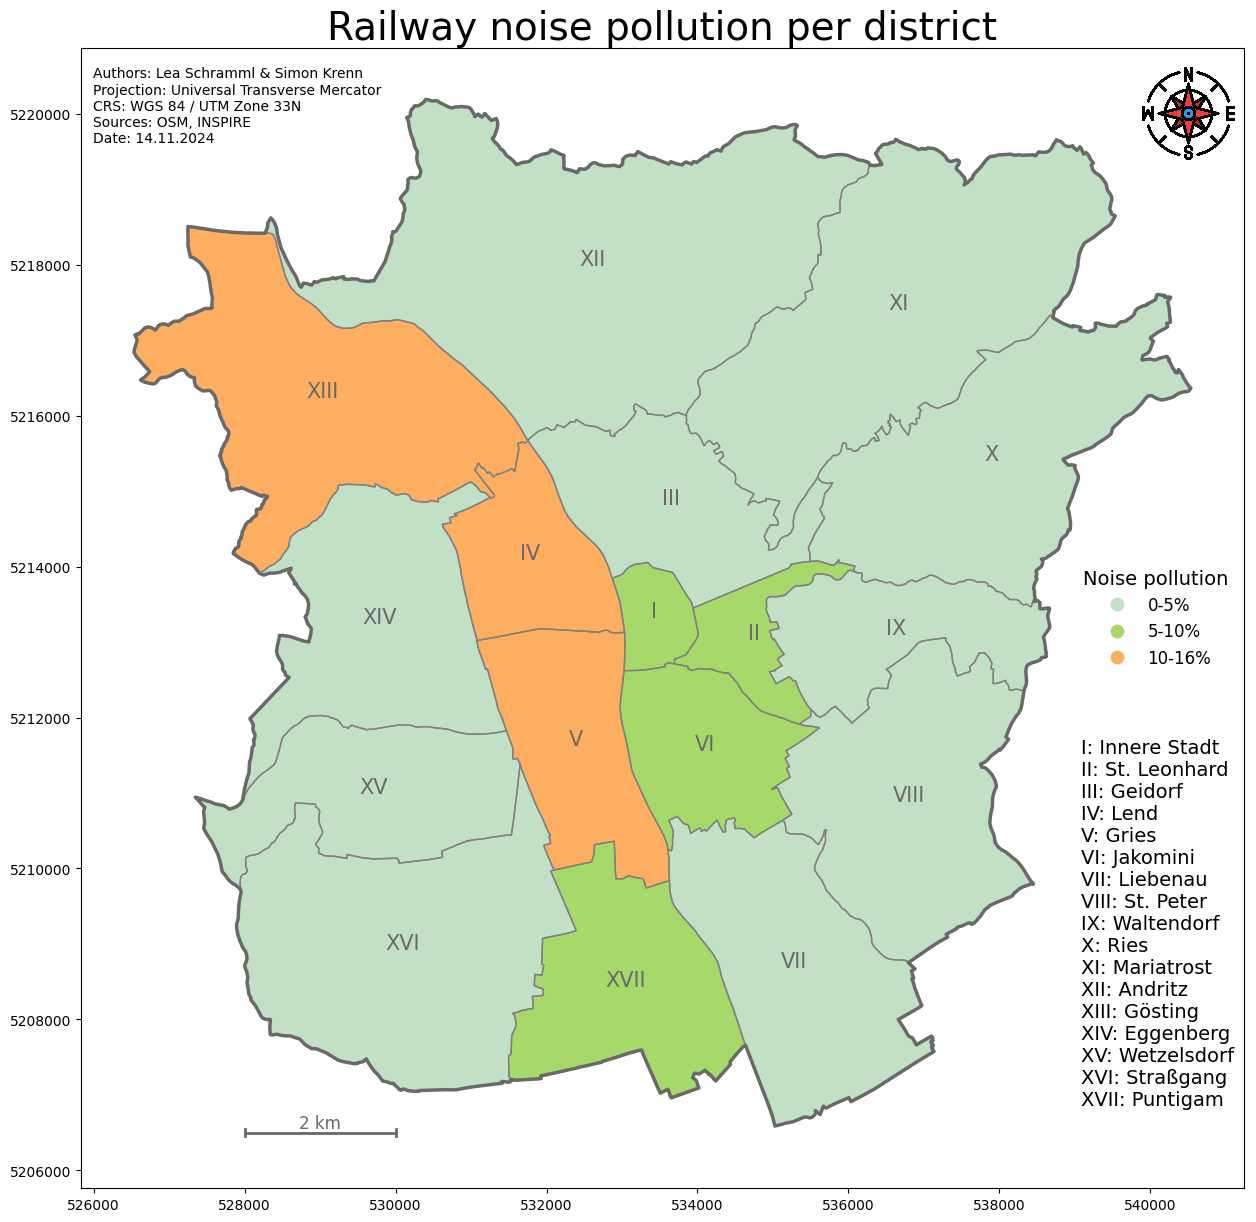

In [8]:
""" creation of maps which categorise the distrcits based on the used noise type """

# add a column with roman letters for better map labels (regarding their usage in the city of Graz itself)
graz_districts['roman_letters'] = ['I', 'VII', 'II', 'III', 'IV', 'V', 'VI', 'VIII', 'IX', 'X', 'XI', 'XII', 'XIII', 'XIV', 'XV', 'XVI', 'XVII']

# create categories for the noise type and define the color gradient
categories = [
    "0-5%", "5-10%", "10-16%"
]
category_bins = [0, 5, 10, 16]
colors = ["#c2e0c6", "#a6d96a", "#fdae61"]

# create a new column, based on the categorie
noise_areas_df['noise_category'] = pd.cut(
    noise_areas_df['railway_noise_pct'], 
    bins=category_bins, 
    labels=categories,
    include_lowest=True)

# merge the df with the geometry of the distrcits, based on the name of the district
graz_districts_categorised = graz_districts.merge(noise_areas_df[['district', 'noise_category']], left_on='name', right_on='district')

# create the map
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

# color coding of the categories
graz_districts_categorised.plot(
    column='noise_category', 
    cmap=mcolors.ListedColormap(colors), 
    legend=True,
    legend_kwds={'title': "Noise pollution", 'loc': 'center right', 'frameon': False, 'fontsize':12, 'title_fontsize':14},
    ax=ax
)

graz_boundary.plot(ax=ax, edgecolor="dimgrey", facecolor="none", linewidth=2.5, zorder = 50,)
graz_districts.plot(ax=ax, edgecolor="grey", facecolor="none", linewidth=1,)

# labelling of the districts
for idx, row in graz_districts.iterrows():
    plt.annotate(
        text=row['roman_letters'], 
        xy=(row.geometry.centroid.x, row.geometry.centroid.y),
        ha='center', color='dimgrey', fontsize=15, zorder=100
    )

# create the scale bar in the same way as before (as well as the north arrow)
scale_length = 2000  
scale_x = 528000  
scale_y = 5206500  

ax.plot([scale_x, scale_x + scale_length], [scale_y, scale_y], color='dimgrey', linewidth=2)

ax.plot([scale_x, scale_x], [scale_y - 50, scale_y + 50], color='dimgrey', linewidth=2)  
ax.plot([scale_x + scale_length, scale_x + scale_length], [scale_y - 50, scale_y + 50], color='dimgrey', linewidth=2)  

ax.text(scale_x + scale_length / 2, scale_y + 10, '2 km', fontsize=12, ha='center', va='bottom', color='dimgrey')

north_arrow_x = 540500  
north_arrow_y = 5220000

img = mpimg.imread('./midterm_project_noise/north_arrow.png')  

imagebox = offsetbox.OffsetImage(img, zoom=0.035)  
ab = offsetbox.AnnotationBbox(imagebox, (north_arrow_x, north_arrow_y), frameon=False)
ax.add_artist(ab)

text_x = 0.01
text_y = 0.90 

# create text boxes again
text_content = """
Authors: Lea Schramml & Simon Krenn
Projection: Universal Transverse Mercator
CRS: WGS 84 / UTM Zone 33N
Sources: OSM, INSPIRE
Date: 14.11.2024
"""

plt.text(
    text_x, text_y, text_content, ha='left', va='bottom', 
    transform=ax.transAxes, fontsize=10, color='black'
)

text_districts = """
I: Innere Stadt
II: St. Leonhard
III: Geidorf
IV: Lend
V: Gries
VI: Jakomini
VII: Liebenau
VIII: St. Peter
IX: Waltendorf
X: Ries
XI: Mariatrost
XII: Andritz
XIII: Gösting
XIV: Eggenberg
XV: Wetzelsdorf
XVI: Straßgang
XVII: Puntigam
"""

text_x_districts = 0.86
text_y_districts = 0.05

plt.text(
    text_x_districts, text_y_districts, text_districts, ha='left', va='bottom', 
    transform=ax.transAxes, fontsize=14, color='black'
)

ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '%1.0f' % x))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '%1.0f' % x))

ax.set_title("Railway noise pollution per district", fontsize=28)

# adapt the legend
legend = ax.get_legend()
for text, color in zip(categories, colors):
    legend.get_texts()[categories.index(text)].set_text(text)

output_file_RWN = "graz_noise_map_RWN.jpg"
plt.savefig(output_file_RWN, dpi=500, format='jpg', bbox_inches='tight')

plt.show()

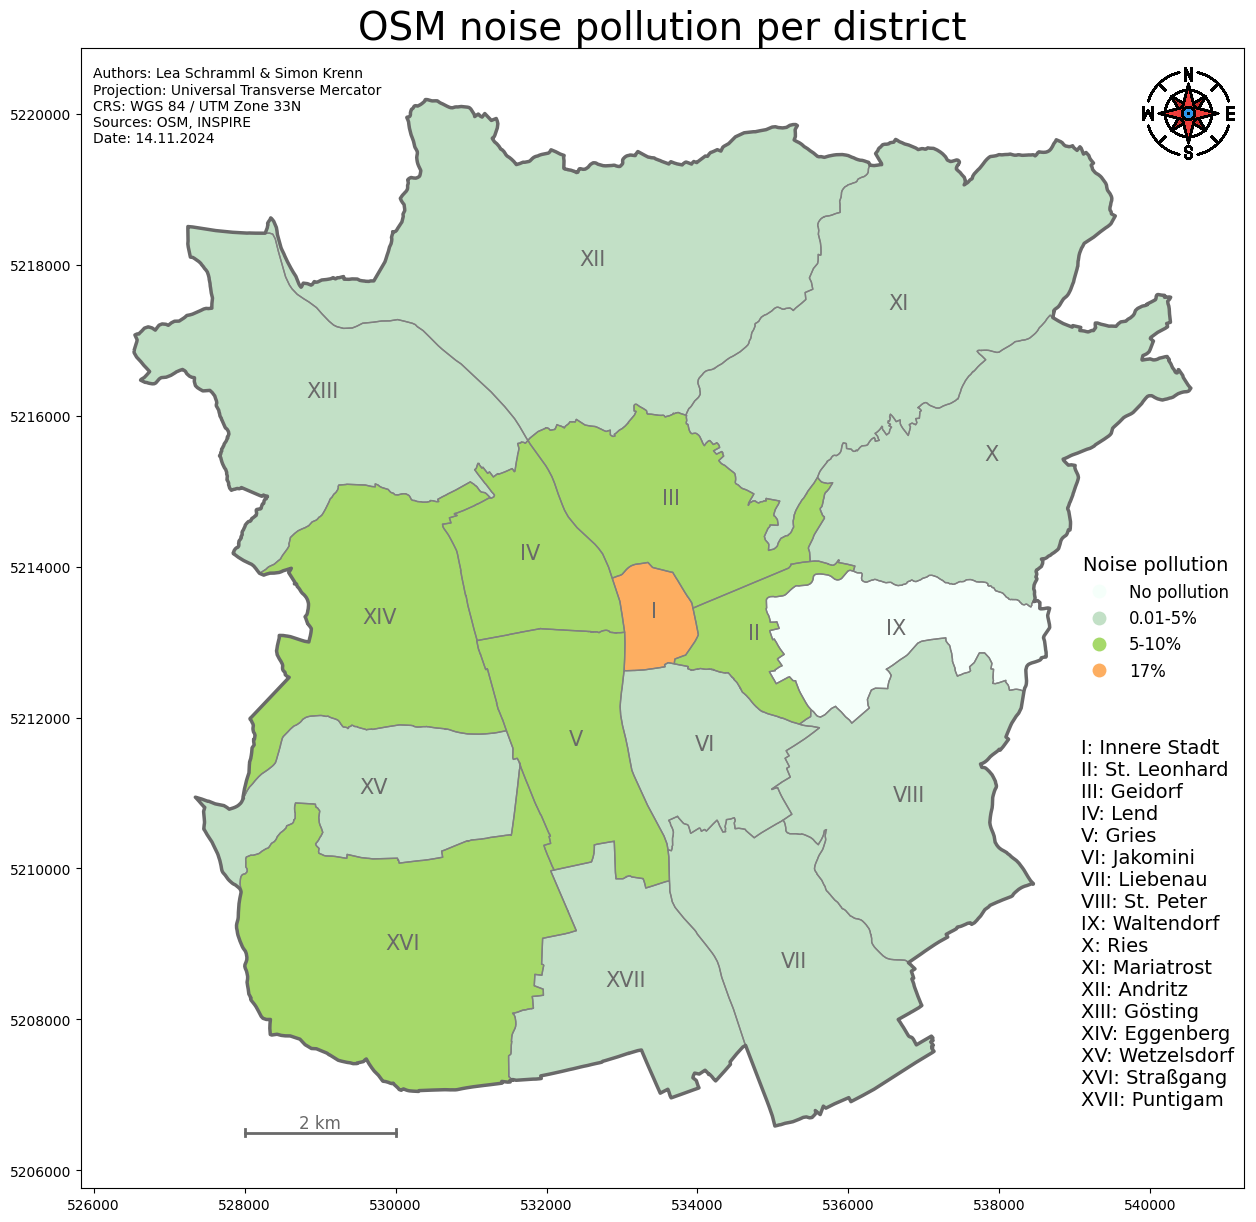

In [9]:
""" creation of maps which categorise the distrcits based on the used noise type """

# add a column with roman letters for better map labels (regarding their usage in the city of Graz itself)
graz_districts['roman_letters'] = ['I', 'VII', 'II', 'III', 'IV', 'V', 'VI', 'VIII', 'IX', 'X', 'XI', 'XII', 'XIII', 'XIV', 'XV', 'XVI', 'XVII']

# create categories for the noise type and define the color gradient
categories = [
    "No pollution", "0.01-5%","5-10%", "17%"
]
category_bins = [0, 0.01, 5, 10, 18,]
colors = ["#f5fffa" , "#c2e0c6", "#a6d96a", "#fdae61"]

# create a new column, based on the categorie
noise_areas_df['noise_category'] = pd.cut(
    noise_areas_df['osm_noise_pct'], 
    bins=category_bins, 
    labels=categories,
    include_lowest=True)

# merge the df with the geometry of the distrcits, based on the name of the district
graz_districts_categorised = graz_districts.merge(noise_areas_df[['district', 'noise_category']], left_on='name', right_on='district')

# create the map
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

# color coding of the categories
graz_districts_categorised.plot(
    column='noise_category', 
    cmap=mcolors.ListedColormap(colors), 
    legend=True,
    legend_kwds={'title': "Noise pollution", 'loc': 'center right', 'frameon': False, 'fontsize':12, 'title_fontsize':14},
    ax=ax
)

graz_boundary.plot(ax=ax, edgecolor="dimgrey", facecolor="none", linewidth=2.5, zorder = 50,)
graz_districts.plot(ax=ax, edgecolor="grey", facecolor="none", linewidth=1,)

# labelling of the districts
for idx, row in graz_districts.iterrows():
    plt.annotate(
        text=row['roman_letters'], 
        xy=(row.geometry.centroid.x, row.geometry.centroid.y),
        ha='center', color='dimgrey', fontsize=15, zorder=100
    )

# create the scale bar in the same way as before (as well as the north arrow)
scale_length = 2000  
scale_x = 528000  
scale_y = 5206500  

ax.plot([scale_x, scale_x + scale_length], [scale_y, scale_y], color='dimgrey', linewidth=2)

ax.plot([scale_x, scale_x], [scale_y - 50, scale_y + 50], color='dimgrey', linewidth=2)  
ax.plot([scale_x + scale_length, scale_x + scale_length], [scale_y - 50, scale_y + 50], color='dimgrey', linewidth=2)  

ax.text(scale_x + scale_length / 2, scale_y + 10, '2 km', fontsize=12, ha='center', va='bottom', color='dimgrey')

north_arrow_x = 540500  
north_arrow_y = 5220000

img = mpimg.imread('./midterm_project_noise/north_arrow.png')  

imagebox = offsetbox.OffsetImage(img, zoom=0.035)  
ab = offsetbox.AnnotationBbox(imagebox, (north_arrow_x, north_arrow_y), frameon=False)
ax.add_artist(ab)

text_x = 0.01
text_y = 0.90 

# create text boxes again
text_content = """
Authors: Lea Schramml & Simon Krenn
Projection: Universal Transverse Mercator
CRS: WGS 84 / UTM Zone 33N
Sources: OSM, INSPIRE
Date: 14.11.2024
"""

plt.text(
    text_x, text_y, text_content, ha='left', va='bottom', 
    transform=ax.transAxes, fontsize=10, color='black'
)

text_districts = """
I: Innere Stadt
II: St. Leonhard
III: Geidorf
IV: Lend
V: Gries
VI: Jakomini
VII: Liebenau
VIII: St. Peter
IX: Waltendorf
X: Ries
XI: Mariatrost
XII: Andritz
XIII: Gösting
XIV: Eggenberg
XV: Wetzelsdorf
XVI: Straßgang
XVII: Puntigam
"""

text_x_districts = 0.86
text_y_districts = 0.05

plt.text(
    text_x_districts, text_y_districts, text_districts, ha='left', va='bottom', 
    transform=ax.transAxes, fontsize=14, color='black'
)

ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '%1.0f' % x))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '%1.0f' % x))

ax.set_title("OSM noise pollution per district", fontsize=28)

# adapt the legend
legend = ax.get_legend()
for text, color in zip(categories, colors):
    legend.get_texts()[categories.index(text)].set_text(text)

output_file_OSM = "graz_noise_map_OSM.jpg"
plt.savefig(output_file_OSM, dpi=500, format='jpg', bbox_inches='tight')

plt.show()

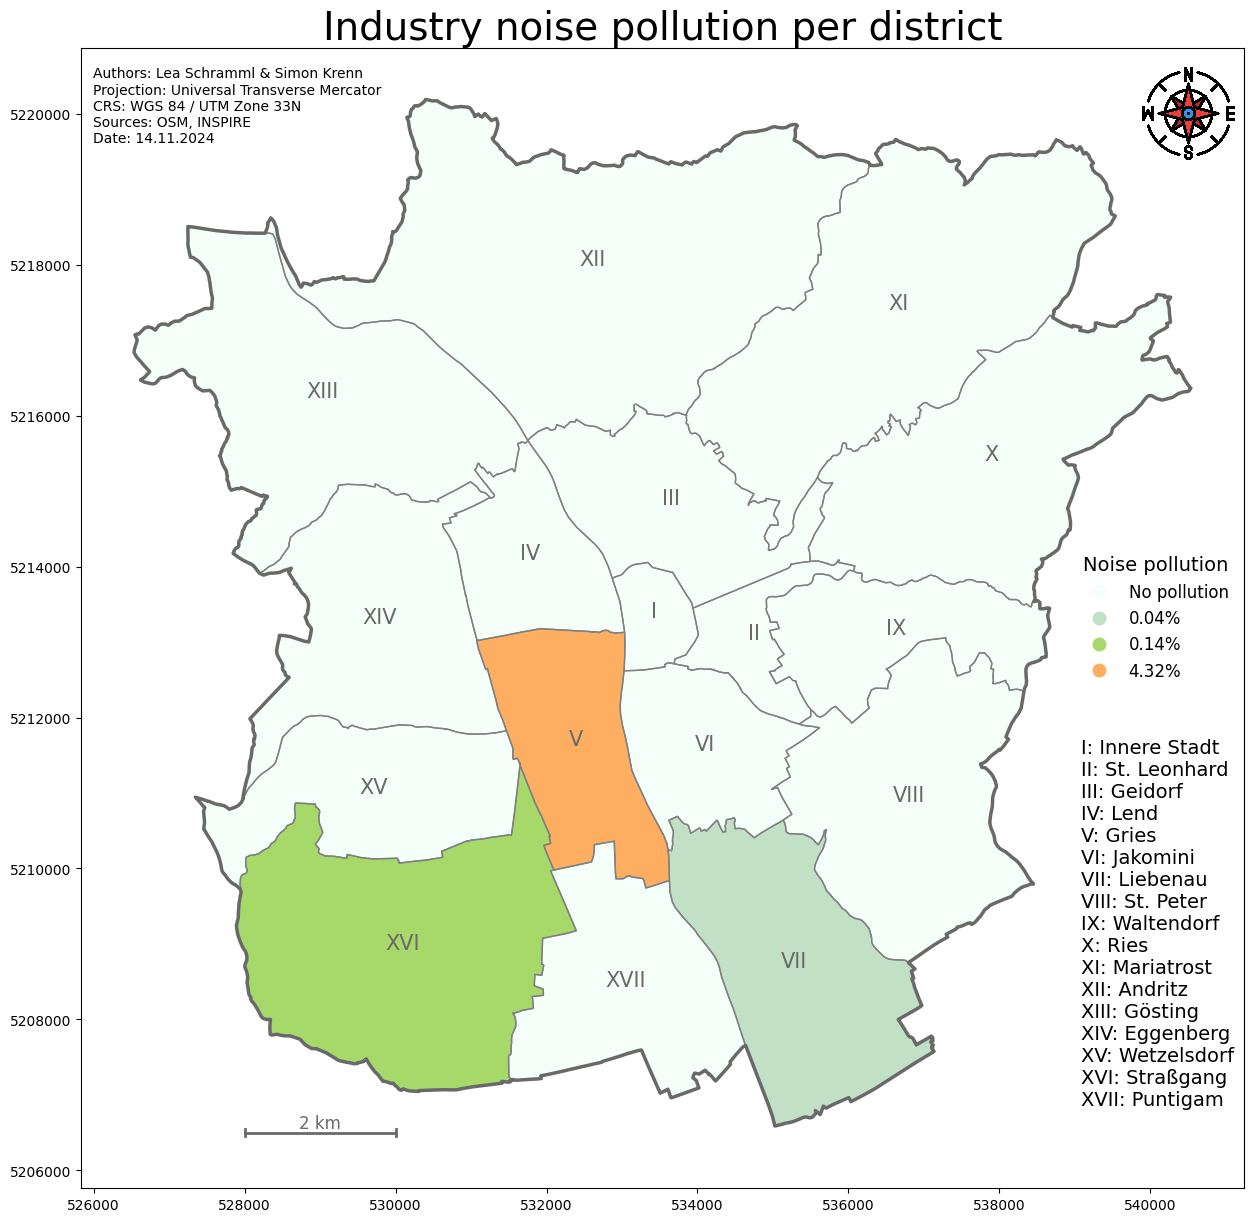

In [10]:
""" creation of maps which categorise the distrcits based on the used noise type """

# add a column with roman letters for better map labels (regarding their usage in the city of Graz itself)
graz_districts['roman_letters'] = ['I', 'VII', 'II', 'III', 'IV', 'V', 'VI', 'VIII', 'IX', 'X', 'XI', 'XII', 'XIII', 'XIV', 'XV', 'XVI', 'XVII']

# create categories for the noise type and define the color gradient
categories = [
    "No pollution", "0.04%","0.14%", "4.32%"
]
category_bins = [0, 0.04, 0.14, 4.32, float('inf')]
colors = ["#f5fffa" , "#c2e0c6", "#a6d96a", "#fdae61"]

# create a new column, based on the categorie
noise_areas_df['noise_category'] = pd.cut(
    noise_areas_df['industry_noise_pct'], 
    bins=category_bins, 
    labels=categories,
    include_lowest=True)

# merge the df with the geometry of the distrcits, based on the name of the district
graz_districts_categorised = graz_districts.merge(noise_areas_df[['district', 'noise_category']], left_on='name', right_on='district')

# create the map
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

# color coding of the categories
graz_districts_categorised.plot(
    column='noise_category', 
    cmap=mcolors.ListedColormap(colors), 
    legend=True,
    legend_kwds={'title': "Noise pollution", 'loc': 'center right', 'frameon': False, 'fontsize':12, 'title_fontsize':14},
    ax=ax
)

graz_boundary.plot(ax=ax, edgecolor="dimgrey", facecolor="none", linewidth=2.5, zorder = 50,)
graz_districts.plot(ax=ax, edgecolor="grey", facecolor="none", linewidth=1,)

# labelling of the districts
for idx, row in graz_districts.iterrows():
    plt.annotate(
        text=row['roman_letters'], 
        xy=(row.geometry.centroid.x, row.geometry.centroid.y),
        ha='center', color='dimgrey', fontsize=15, zorder=100
    )

# create the scale bar in the same way as before (as well as the north arrow)
scale_length = 2000  
scale_x = 528000  
scale_y = 5206500  

ax.plot([scale_x, scale_x + scale_length], [scale_y, scale_y], color='dimgrey', linewidth=2)

ax.plot([scale_x, scale_x], [scale_y - 50, scale_y + 50], color='dimgrey', linewidth=2)  
ax.plot([scale_x + scale_length, scale_x + scale_length], [scale_y - 50, scale_y + 50], color='dimgrey', linewidth=2)  

ax.text(scale_x + scale_length / 2, scale_y + 10, '2 km', fontsize=12, ha='center', va='bottom', color='dimgrey')

north_arrow_x = 540500  
north_arrow_y = 5220000

img = mpimg.imread('./midterm_project_noise/north_arrow.png')  

imagebox = offsetbox.OffsetImage(img, zoom=0.035)  
ab = offsetbox.AnnotationBbox(imagebox, (north_arrow_x, north_arrow_y), frameon=False)
ax.add_artist(ab)

text_x = 0.01
text_y = 0.90 

# create text boxes again
text_content = """
Authors: Lea Schramml & Simon Krenn
Projection: Universal Transverse Mercator
CRS: WGS 84 / UTM Zone 33N
Sources: OSM, INSPIRE
Date: 14.11.2024
"""

plt.text(
    text_x, text_y, text_content, ha='left', va='bottom', 
    transform=ax.transAxes, fontsize=10, color='black'
)

text_districts = """
I: Innere Stadt
II: St. Leonhard
III: Geidorf
IV: Lend
V: Gries
VI: Jakomini
VII: Liebenau
VIII: St. Peter
IX: Waltendorf
X: Ries
XI: Mariatrost
XII: Andritz
XIII: Gösting
XIV: Eggenberg
XV: Wetzelsdorf
XVI: Straßgang
XVII: Puntigam
"""

text_x_districts = 0.86
text_y_districts = 0.05

plt.text(
    text_x_districts, text_y_districts, text_districts, ha='left', va='bottom', 
    transform=ax.transAxes, fontsize=14, color='black'
)

ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '%1.0f' % x))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '%1.0f' % x))

ax.set_title("Industry noise pollution per district", fontsize=28)

# adapt the legend
legend = ax.get_legend()
for text, color in zip(categories, colors):
    legend.get_texts()[categories.index(text)].set_text(text)

output_file_IN = "graz_noise_map_IN.jpg"
plt.savefig(output_file_IN, dpi=500, format='jpg', bbox_inches='tight')

plt.show()

In [11]:
""" creation of an interactive map with folium """

# basemap, located/starting in the city of graz, with the tile format "Cartodb Positron" (not that "bright and aggressive as the normal OSM tile)

m = folium.Map(location=[47.0707, 15.4395], zoom_start=12, tiles="Cartodb Positron", control_scale=True)

# insert the boundaries of graz
folium.GeoJson(
    graz_boundary,
    name="Graz Boundary",
    style_function=lambda x: {
        "fillColor": "none",
        "color": "black",
        "weight": 3
    }
).add_to(m)

# add the noise data to the map

folium.GeoJson(
    gdf_industry_filtered,
    name="Industry",
    style_function=lambda x: {
        "fillColor": "purple",
        "color": "purple",
        "weight": 1
    }
).add_to(m)

folium.GeoJson(
    gdf_railway_filtered,
    name="Railway",
    style_function=lambda x: {
        "fillColor": "blue",
        "color": "blue",
        "weight": 1
    }
).add_to(m)

folium.GeoJson(
    gdf_roads_filtered,
    name="Roads",
    style_function=lambda x: {
        "fillColor": "red",
        "color": "red",
        "weight": 1
    }
).add_to(m)

folium.GeoJson(
    osm_features,
    name="OSM Features",
    style_function=lambda x: {
        "fillColor": "lightgreen",
        "color": "darkgreen",
        "weight": 1
    }
).add_to(m)

# implement an Address search with the Geocoder-Plugin
Geocoder(collapsed=False).add_to(m)

# add a layer control (visibility on/off)
folium.LayerControl().add_to(m)

# save the map as an html file (due to the usage of a very old and less powerful laptop)
m.save("graz_interactive_noise_map.html")
